## Introduction
I deliberately chose a really small and clean dataset (iris) as I wanted to try different pipeline configurations. Big dataset tend to slow my computer and make it impossible to try quick iterations.
I will try to perform features reduction & clustering on the same dataset to improve classification.

### 1: EDA of the Iris Dataset
### 2: Clustering for classification
### 3: Mixed PCA & clustering
### 4: DBSCAN with home-made grid search

## Conclusion


### 1: EDA of the Iris dataset

First, imports for this EDA:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data = pd.read_csv('iris_data.csv')

The iris dataset has only 4 features (sepal width & length, petal width & length) and the target is the name of the specy (setosa, versicolor, virginica).

In [3]:
data.head(10)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


All features are float, label is a string object:

In [4]:
data.dtypes

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object

Only 150 observations, this is a really small dataset! And the features seem rather gaussian for this first look, but we will check in details later.

In [5]:
data.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Aret there any NaNs in the dataset? No, gosh I wish all datasets were that easy :)

In [6]:
data.isna().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

Let's first make a list of our features, by using the float selection:

In [7]:
float_columns =  data.columns[data.dtypes == "float64"].tolist()
float_columns

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

And we can check the skewness of all these features:

In [8]:
skew_columns = (data[float_columns]
                .skew()
                .sort_values(ascending=False))

skew_columns

sepal_width     0.334053
sepal_length    0.314911
petal_width    -0.104997
petal_length   -0.274464
dtype: float64

Features are not really skewed, I think we can skip the normalization process. Let's check if some features are correlated:

In [9]:
# The correlation matrix
corr_mat = data[float_columns].corr()

# Strip out the diagonal values for the next step
for x in range(len(float_columns)):
    corr_mat.iloc[x,x] = 0.0
    
corr_mat

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,0.000000,-0.109369,0.871754,0.817954
sepal_width,-0.109369,0.000000,-0.420516,-0.356544
petal_length,0.871754,-0.420516,0.000000,0.962757
petal_width,0.817954,-0.356544,0.962757,0.000000


Petal width & petal length are highly correlated! Sepal length & petal length / width are quite correlated as well. We could simply remove a feature, but we will use a PCA to decrease the dimensionality. This should work well as some features are highly correlated.

Now, as it is a really small dataset, let's make a pairplot:

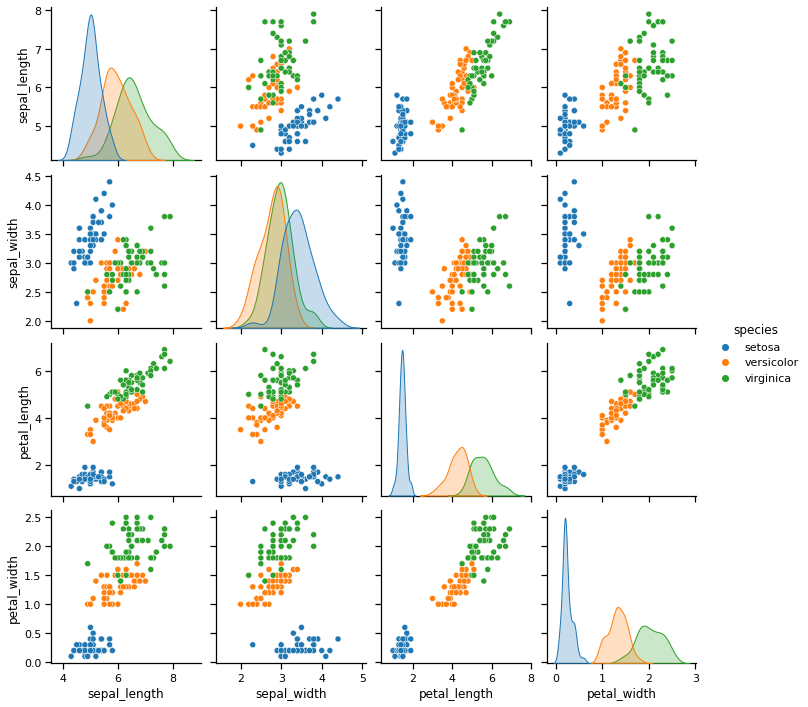

In [10]:
sns.set_context('notebook')
sns.pairplot(data, hue='species')

We can confirm multiple things here:

1. Features distribution are indeed quite gaussian.
2. Petal length & width are highly correlated
3. Setosa label is clearly separated from the others, this one should work better for a clustering method.

I will scale the features after declaring the split, integrated to a pipeline. I still have to encode the labels, let's do it now:

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['species'] = le.fit_transform(data['species'])

data_orig = data.copy(deep=True) # Deep copy here, to keep the original data safe. Just in case...
data.sample(10)

,sepal_length,sepal_width,petal_length,petal_width,species
58,6.6,2.9,4.6,1.3,1
22,4.6,3.6,1.0,0.2,0
133,6.3,2.8,5.1,1.5,2
50,7.0,3.2,4.7,1.4,1
85,6.0,3.4,4.5,1.6,1
88,5.6,3.0,4.1,1.3,1
98,5.1,2.5,3.0,1.1,1
101,5.8,2.7,5.1,1.9,2
116,6.5,3.0,5.5,1.8,2
144,6.7,3.3,5.7,2.5,2


And that is all, this was really quick. Let's continue with the main goal of this exercise:

### 2. Simple clustering with K-means

And first, some imports:

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix


Let's split the dataset in features & target and check if the dataset is balanced:

In [13]:
X = data.drop('species', axis=1)
y = data['species']

y.value_counts()

2    50
1    50
0    50
Name: species, dtype: int64

We have 50 observations for each class, the dataset is balanced. I could use the accuracy as score, but I prefer to use the roc-auc, it should be better suited. 

I will first use a stratified shuffle split with 3 splits as validation and then build pipelines with greater complexities. First, let's use a logistic regression without clustering to see the basic efficacy of our classification estimator:

In [14]:
StrShSpl = StratifiedShuffleSplit(n_splits=3, random_state=1)

# Really simple pipeline with a scaler and an estimator.
pipe1 = [('scaler', StandardScaler()),
         ('estimator', LogisticRegression(solver='liblinear'))]
pipe1 = Pipeline(pipe1)

scores = []
for train_index, test_index in StrShSpl.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    pipe1.fit(X_train, y_train)
    y_predict = pipe1.predict(X_test)
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2]),
                        label_binarize(y_predict, classes=[0,1,2]),
                        average='weighted')
    acc = accuracy_score(y_test, y_predict)
    
    scores.append(auc)


We accumulated the scores of all our splits, let's see the mean of them:

In [15]:
print('Scores were')
print(scores)
print('Average:')
print(np.mean(scores))

Scores were
[0.9, 0.9, 0.9]
Average:
0.9


Average accuracy of 0.9 and all the split have the same accuracy. What about the confusion matrix?

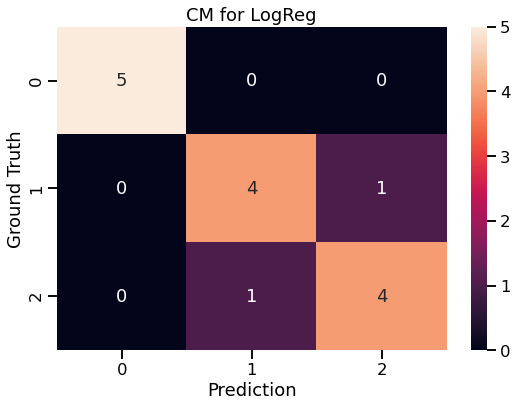

In [16]:
# This takes only the last y_predict from the loop, maybe not the most representative one.
cm = confusion_matrix(y_test, y_predict)

# I will use this function a lot.
def plot_cm(cm, title= 'None'):
    sns.set_context('talk')

    fig, ax = plt.subplots(figsize=(8, 6))

    ax = sns.heatmap(cm, annot=True, fmt='d');
    ax.set(title=title,
           xlabel = 'Prediction',
           ylabel = 'Ground Truth');

    plt.tight_layout()
    
plot_cm(cm, title='CM for LogReg')

Now with a K-means clustering to transform our dataset before using an estimator. I set the number of cluster to 3 as I know it is the case. We have to know that a pipeline uses the fit_transform method of each step to replace the dataset along the way. The K-means will actually replace the original dataset by its own grouping prediction.

In [17]:
pipe2 = [('scaler', StandardScaler()),
         ('cluster', KMeans(n_clusters=3)), # The only new thing.
         ('estimator', LogisticRegression(solver='liblinear'))]

pipe2 = Pipeline(pipe2)
scores = []

for train_index, test_index in StrShSpl.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    pipe2.fit(X_train, y_train)
    y_predict = pipe2.predict(X_test)
    
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2]),
                        label_binarize(y_predict, classes=[0,1,2]),
                        average='weighted')
    acc = accuracy_score(y_test, y_predict)
    
    scores.append(auc)

In [18]:
print('Scores were')
print(scores)
print('Average:')
print(np.mean(scores))

Scores were
[0.8, 0.85, 0.8]
Average:
0.8166666666666668


Interestingly, we decreased our classifier score when using a simple clustering. This is actually normal, as we decrease the amount of information when we replace our data by the result of a clustering algorithm. And we introduced some randomness in the result, which is normal as well as the K-means initialization starts with random points. We have to combine these clustering data with the original data. As an example, let's plot the confusion matrix from the last iteration of the loop:

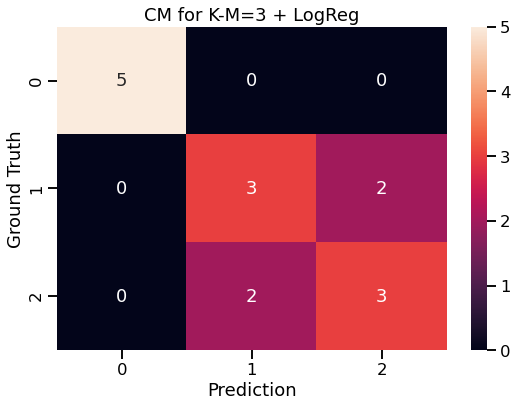

In [19]:
# This takes only the last y_pred from the loop, maybe not the best one.
cm = confusion_matrix(y_test, y_predict)

plot_cm(cm, title='CM for K-M=3 + LogReg')


We can se the label 0 (setosa) is well classified, the rest is rather bad.

To combine features, I will use FeatureUnion:
https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html
It allows transforming the data by multiple methods and concatenate the results in the end. However, you need a fit_transform method to use it. So to add the original data, I simply declare an empty FunctionTransformer.

In [20]:
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer

In [21]:
# Still the same pipeline
scaler = StandardScaler()
km = KMeans(n_clusters=3)
logreg = LogisticRegression(solver='liblinear')

# An empty Function tranformer will do nothing and simply pass the data
identity = FunctionTransformer() 

# combining here: original data + clustering result.
combined_features = FeatureUnion([("identity", identity),("km", km)])
X_features = combined_features.fit(X_train, y_train).transform(X_train) 

# This should give 4 + 3 = 7 features.
print("Combined space of original & engineered features:", X_features.shape[1], "features") 

# Pipeline here: Scaling, combinations of features & Clustering and then estimator
pipe3 = Pipeline([("scaler", scaler), ("features", combined_features), ("lr", logreg)])

scores = []

for train_index, test_index in StrShSpl.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    pipe3.fit(X_train, y_train)
    y_predict = pipe3.predict(X_test)
    
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2]),
                        label_binarize(y_predict, classes=[0,1,2]),
                        average='weighted')
    acc = accuracy_score(y_test, y_predict)
    
    scores.append(auc)
    



Combined space of original & engineered features: 7 features


We can see that we are now using a data set with 7 features: the 4 original and the 3 clustered results. What are the scores?

In [22]:
print('Scores were')
print(scores)
print('Average:')
print(np.mean(scores))

Scores were
[0.9, 0.95, 0.95]
Average:
0.9333333333333332


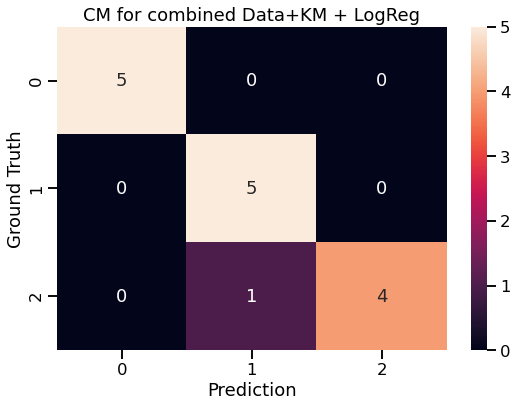

In [23]:
# This takes only the last y_pred from the loop, maybe not the best one.
cm = confusion_matrix(y_test, y_predict)

plot_cm(cm, title='CM for combined Data+KM + LogReg')

This concatenation of features and cluster results greatly improved our results. As expected, the label 0 is perfectly classified. This is great and it was expected. 

However, I realized a stratified shuffle split is probably not the best choice for small datasets: when doing the splits, it separates the train and test in 3 different subsets, without overlap. So it will make the predict on roughly 16 observations (50/3). This makes a pretty fickle result, as a single misclassification will have a big effect on the final score. Starting from now, I will use KFold cross validation to improve this matter. GridSearch CV uses a KFold, so it should be better. And instead of passing the original data, I will reduce the dimensionality by PCA before concatenating with the clustering results.

### 2. PCA & clustering for classification

First, let's declare again our features & targets. And randomly split in train and test sets:

In [24]:
from sklearn.model_selection import train_test_split

X = data.drop('species', axis=1)
y = data['species']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=61) 
# This should give around 50 observations for the test set.

I will then use a combination of PCA and clustering to transform the dataset. In short: I will perform a PCA on the original data and store the result. Then a K-means on the original data and store the result. Then combine these 2 results in a new dataset with FeatureUnion and use a classifier on it. With GridSearchCV, I can walk on different parameters during each step of this process.

Imports:

In [25]:
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV

With the default settings I set, the PCA will reduce the dataset to 2 features. And the clustering will create 3 features.
So we will go from 4 original features to 2 + 3 engineered features:

In [41]:
# First, a scaler. Same than before.
scaler = StandardScaler()

# Second, PCA on original data
pca = PCA(n_components=1)

# Third, clustering on original data too
km = KMeans(n_clusters=10)

print("Original space has", X.shape[1], "features")

# Combine the features here, so we will have the result of the PCA concatenated to the result of the clustering
combined_features = FeatureUnion([("pca", pca), ("km", km)])

# Use combined features to transform the dataset:
# X_train and y_train are only declarative (I pass them later), but to simply put X and y may create data leakage 
# if I do something wrong. It happens.
X_features = combined_features.fit(X_train, y_train).transform(X_train) 
print("Combined space has", X_features.shape[1], "features")

Original space has 4 features
Combined space has 11 features


This worked, we went from 4 original features to 5 engineered features. Now, let's create a pipeline around this:

In [48]:
# Classification by a logistic regression, to be simple. But we could play with this as well.
logreg = LogisticRegression(solver='liblinear')

# Pipeline here: Scaling, combinations of PCA & Clustering and then estimator
pipeline = Pipeline([("scaler", scaler), ("features", combined_features), ("lr", logreg)])

# Parameter grid with "__" to reach each level
param_grid = dict(features__pca__n_components=[1], # 4 original features, so Max of 4.
                  features__km__n_clusters= [1], #np.arange(2, 15, 1), # 1 means no clustering.
                  lr__solver=['liblinear'])

# Grid search object here.
km_search = GridSearchCV(pipeline, param_grid=param_grid, cv=3, scoring='roc_auc_ovo')

# Aaaaand the final fit here.
km_search.fit(X_train, y_train)

# Let's see what are the best parameters found:
print('Best estimator:')
print(km_search.best_estimator_)
print('Best score:')
print(km_search.best_score_)

C:\Users\Syla\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Syla\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Syla\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Syla\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:8

Best estimator:
Pipeline(steps=[('scaler', StandardScaler()),
                ('features',
                 FeatureUnion(transformer_list=[('pca', PCA(n_components=1)),
                                                ('km', KMeans(n_clusters=1))])),
                ('lr', LogisticRegression(solver='liblinear'))])
Best score:
0.9810956790123457


The auc score is greatly increased compared to before.
The gridsearchCV finds a PCA with 3 components instead of 4 original features. This is great, as we knew that 2 features were highly correlated. The GridSearch finds an optimal around 10 clusters. But actually, we have to plot the score versus all the parameters to use as an elbow method. All the needed metrics are in the cv_results_ generated object.

In [28]:
# Convert the metrics to a DataFrame
results = pd.DataFrame(km_search.cv_results_)

# Keeping only the columns I am interested in.
results_sub = results[['param_features__km__n_clusters', 'param_features__pca__n_components', 'mean_test_score']]

# To be quick, grouping by parameter values and taking the average. I did not want to plot a 60D graph.
plot_km = results_sub.groupby('param_features__km__n_clusters').mean()
plot_pca = results_sub.groupby('param_features__pca__n_components').mean()

And plot these metrics:

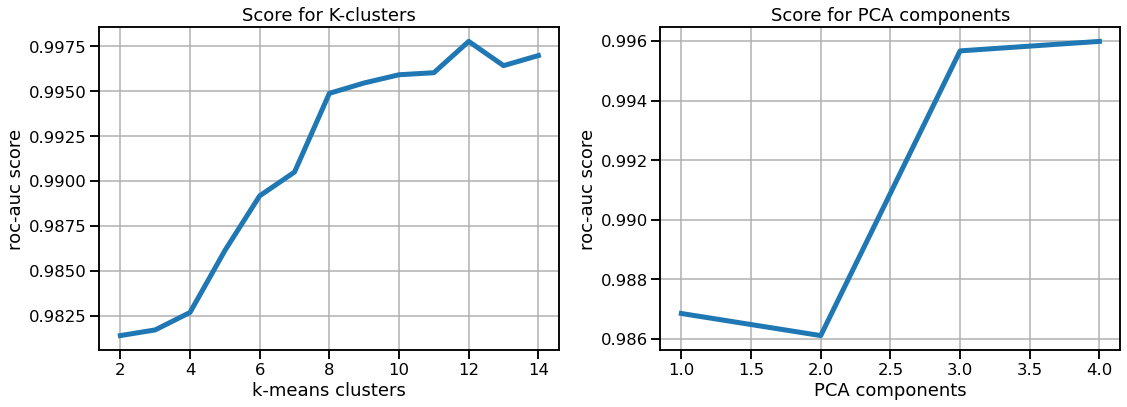

In [29]:
sns.set_context('talk')

fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(16, 6)

# km plot on the left
ax = axList[0]   

ax.plot(plot_km, linewidth=5)
ax.set(xlabel='k-means clusters',
       ylabel='roc-auc score',
       title='Score for K-clusters')
ax.grid(True)    


# PCA plot on the right
ax = axList[1]   

ax.plot(plot_pca, linewidth=5)
ax.set(xlabel='PCA components',
       ylabel='roc-auc score',
       title='Score for PCA components')
ax.grid(True)   

plt.tight_layout()

We can see that even if we were expecting 3 clusters, the score is better if we consider around 10 clusters. The curve flattens after that. For the PCA, the elbow point is clearly at 3 components, which was expected.

Let's try this best fit on our test set and get some metrics:

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import label_binarize

In [31]:
# km_search is the best model, already fitted.
y_pred = km_search.best_estimator_.predict(X_test)

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

accuracy = accuracy_score(y_test, y_pred )

auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2]),
                    label_binarize(y_pred, classes=[0,1,2]),
                    average='weighted')

# Last, the confusion matrix
cm = confusion_matrix(y_test, y_pred)

km_metrics= pd.Series({'precision':precision, 'recall':recall, 
                       'fscore':fscore, 'accuracy':accuracy,
                       'auc':auc}, 
                      name='PCA+km+lr_results')
# Display the metrics here
km_metrics

precision    0.955556
recall       0.955556
fscore       0.955556
accuracy     0.955556
auc          0.966667
Name: PCA+km+lr_results, dtype: float64

Our metrics are pretty good. Let's plot the confusion matrix:

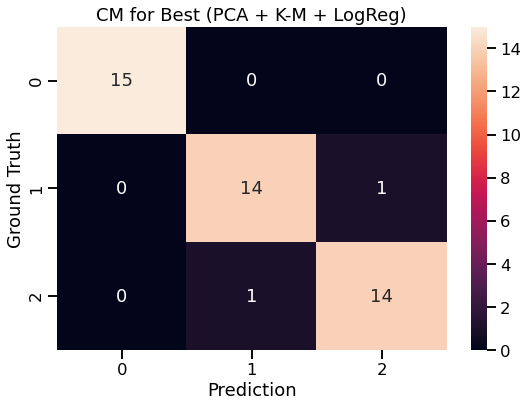

In [32]:
plot_cm(cm, title='CM for Best (PCA + K-M + LogReg)')

As expected, the label "0" (setosa) is perfectly classified. Classification of the 2 other species seems better. This is a great example showing the effect of combining both PCA and clustering to help a classification. Moreover, as we use bigger splits the result is probably more robust.


### 3. DBSCAN on home-made gridsearch.

I wanted to use a DBSCAN method, but it does not come with a fit_transform method. This is annoying because it means we cannot use it in pipelines or with gridsearch. So I decided to make my own gridsearch, a bit like one of the showed exercises.

In [33]:
from sklearn.model_selection import KFold # I gonna use a K-Fold for validation
from sklearn.cluster import DBSCAN

# Product to generate all the possible parameters combinations.
from itertools import product

# Distances and number of samples in clusters for the gridsearch.
eps_list = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
nclu_list = [3, 4, 5, 6, 7]

# I will use these, creating a pipeline in the for loop.
scaler = StandardScaler()
kf = KFold(n_splits=3, shuffle = True)
estimator = LogisticRegression()


In [34]:
def get_avg_acc_3splits(estimator, X, y): # Fit and predict for each KFold.
    auc_list = []
    for train_index, test_index in kf.split(X, y): # For each KFold, define the train & test sets.
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # I have to scale the data here. Doing it before would be data leakage between train & test set. 
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Fit the estimator, predict and measure the auc.
        estimator.fit(X_train, y_train)
        y_predicted = estimator.predict(X_test)
        
        auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2]),
                            label_binarize(y_predicted, classes=[0,1,2]),
                            average='weighted')
        acc = accuracy_score(y_test, y_predicted)
        
        auc_list.append(auc)
        
    return np.mean(auc_list) # Return the auc mean from all the folds.
    

In [35]:
def add_DBSCAN(data, eps, nclu): # Modified the original function, it was impure.
    dbs = DBSCAN(eps=eps, min_samples=nclu)
    
    # DBSCAN does not have a fit_transform method, but a fit_predict. Not really consistent...
    dbs_col = pd.Series(dbs.fit_predict(data)) 
    
    # One-hot-encode the obtained columns and concatenate the to the original data.
    dbs_cols = pd.get_dummies(dbs_col, prefix='dbs_cluster')
    return pd.concat([data, dbs_cols], axis=1)

In [36]:
metrics = list()

# Main loop here, running through every eps / n_clu possible combinations
for eps, nclu in product(eps_list, nclu_list): 
    
    # First, add the created DBSCAN columns to the original data
    X_upgraded = add_DBSCAN(X, eps, nclu)
    
    # Then, get the KFold and estimator.
    auc = get_avg_acc_3splits(estimator, X_upgraded, y)
    
    # Append the obtained metrics to the dictionary with eps & n_clu values.
    metrics.append(pd.Series({'eps':eps, 'n_clu':nclu, 
                              'roc_auc':auc}))


And plot the resulting scores with the corresponding eps and n_clu values:

In [37]:
df = pd.DataFrame(metrics).sort_values(by='roc_auc', ascending=False)

cm = sns.light_palette("green", as_cmap=True)
colored_metrics = df[:10].style.background_gradient(subset=['roc_auc'], low=.96, high=0.98, cmap=cm).set_precision(4)
colored_metrics = colored_metrics.highlight_max(subset=['roc_auc'], axis=0, color='green')

colored_metrics

,eps,n_clu,roc_auc
3,0.0500,6.0000,0.9771
2,0.0500,5.0000,0.9708
11,0.2000,4.0000,0.9705
10,0.2000,3.0000,0.9693
5,0.1000,3.0000,0.9688
28,0.5000,6.0000,0.9666
15,0.3000,3.0000,0.9659
0,0.0500,3.0000,0.9658
29,0.5000,7.0000,0.9656
18,0.3000,6.0000,0.9653


The highest score is obtained with eps = 0.1 & n_clu = 4. However, it is better to plot the scores vs hyperparameters as previously shown:

In [38]:
plot_eps = pd.DataFrame(metrics).groupby('eps').mean().drop(['n_clu'], axis=1)
plot_n_clu = pd.DataFrame(metrics).groupby('n_clu').mean().drop(['eps'], axis=1)

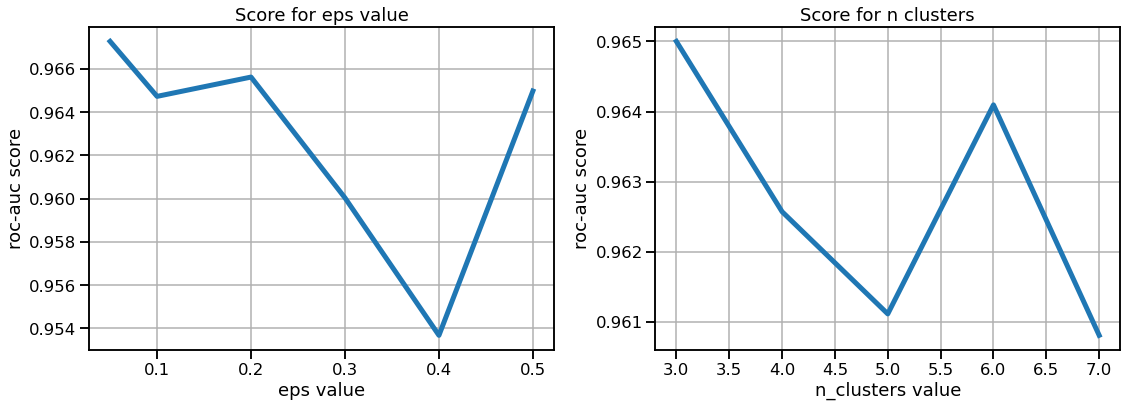

In [39]:
sns.set_context('talk')

fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(16, 6)

# km plot on the left
ax = axList[0]   

ax.plot(plot_eps, linewidth=5)
ax.set(xlabel='eps value',
       ylabel='roc-auc score',
       title='Score for eps value')
ax.grid(True)    


# PCA plot on the right
ax = axList[1]   

ax.plot(plot_n_clu, linewidth=5)
ax.set(xlabel='n_clusters value',
       ylabel='roc-auc score',
       title='Score for n clusters')
ax.grid(True)   

plt.tight_layout()

It seems there is an elbow point around 0.1 for eps and 4 for n_clusters.
This could be optimal hyperparameters for this classification pipeline.
In general, the score is slightly lower than with the previous method using PCA and K-means. And of course, without pipeline, the code is not as clean.

## Conclusion

I chose the dataset "iris" for its simplicity of use and tried multiple variations of clustering algorithms in combinations with PCA and logistic regression for classification. From my trials, I could say that the pipeline combining feature reduction by PCA (3 features) and clustering by K-means (10 clusters) is the best choice for prediction on this dataset. Other methods such as DBS or logistic regression only did not perform as well.

However, there are multiple other things to take:

* A clustering method alone is not a good choice for classification, as it decreases the amount of information in the data. It is better to concatenate the result to the original data.
* FeatureUnion is a great tool for concatenating different preprocessors, such as cluster or PCA methods. It is well combined with GridSearchCV.
* StratifiedShuffleSplit may not be the best tool for small dataset, as it generates too small test sets. High chance it produces fickle results.
* SKLearn is not that consistent, some functions lack essential methods such as fit_transform. This could have an impact in the choice of the method, sharing between simplicity of the code and ideal algorithm.


### To improve
* I have to try this kind of pipeline on bigger datasets. However, as I said, I wanted to make quick iterations on pipelines so "iris" is perfect for that.
* I was a bit surprised to see that the optimal k-means value for classification is around 10 clusters: we do know there are only 3 labels in this dataset. I do not really know if I should consider this as an artefact and manually set the number of clusters to 3, if this could be a hint that we have sub-classes in our dataset, or if I should not care and simply keep it this way: it it works better with 10, keep it at 10. I guess that's what we call experience.